# Walmart - Store Sales Forecasting
One challenge of modeling retail data is the need to make decisions based on limited history. If Christmas comes but once a year, so does the chance to see how strategic decisions impacted the bottom line. 

We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains many departments, and we must project the sales for each department in each store. To add to the challenge, selected holiday markdown events are included in the dataset. These markdowns are known to affect sales, but it is challenging to predict which departments are affected and the extent of the impact.

# Data

Datasets is download from https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data

We are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments, and the task is predicting the department-wide sales for each store.

In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**stores.csv**

This file contains anonymized information about the 45 stores, indicating the type and size of store.

**train.csv**

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields:

Store - the store number
Dept - the department number
Date - the week
Weekly_Sales -  sales for the given department in the given store
IsHoliday - whether the week is a special holiday week
test.csv

This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

**features.csv**

This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13

Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13

Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13

Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

## 1. Set up and Understanding Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [2]:
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")
test= pd.read_csv("test.csv")
train=pd.read_csv("train.csv")

In [3]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [5]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
print(train.shape)
print(test.shape)
print(stores.shape)
print(features.shape)

(421570, 5)
(115064, 4)
(45, 3)
(8190, 12)


### Change the Date column into Datetime

In [8]:
features['Date'] = pd.to_datetime(features['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [9]:
train.loc[0, 'Date']

Timestamp('2010-02-05 00:00:00')

### Merge Data into 1 DataFrame for easy analysing the data and preprocessing

In [10]:
# Merge Training Data with Features
all_train = train.merge(features, how='left', on=['Store','Date','IsHoliday'])

# Merge Testing Data with Features
all_test = test.merge(features, how='left', on=['Store','Date','IsHoliday'])

In [11]:
# Merge Training Data with Stores
all_train = all_train.merge(stores, how='left', on=['Store'])

# Merge Testing Data with Stores
all_test = all_test.merge(stores, how='left', on=['Store'])

In [12]:
all_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [13]:
all_test.tail()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
115059,45,98,2013-06-28,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221
115060,45,98,2013-07-05,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221
115063,45,98,2013-07-26,False,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,B,118221


In [14]:
all_train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [15]:
all_test.columns

Index(['Store', 'Dept', 'Date', 'IsHoliday', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Type', 'Size'],
      dtype='object')

In [16]:
# Changing IsHoliday from boolean into numerical
def IsHoliday(x):
    if x==True: return 1
    else: return 0

In [17]:
all_train['IsHoliday'] = all_train['IsHoliday'].apply(IsHoliday)
all_test['IsHoliday'] = all_test['IsHoliday'].apply(IsHoliday)

In [242]:
all_train.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315


In [18]:
all_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


## 2. Data Preprocessing

In [19]:
all_train.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

In [20]:
all_train.isnull().sum()/len(all_train) * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
Type             0.000000
Size             0.000000
dtype: float64

In [21]:
all_test.isnull().sum()

Store               0
Dept                0
Date                0
IsHoliday           0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
Type                0
Size                0
dtype: int64

In [22]:
all_test.isnull().sum()/len(all_test) * 100

Store            0.000000
Dept             0.000000
Date             0.000000
IsHoliday        0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1        0.129493
MarkDown2       24.879198
MarkDown3        8.542203
MarkDown4       11.200723
MarkDown5        0.000000
CPI             33.165890
Unemployment    33.165890
Type             0.000000
Size             0.000000
dtype: float64

Fill Temperature, CPI and Unemployment missing value with mean

In [23]:
all_train['Temperature'].fillna(all_train['Temperature'].mean(), inplace=True)
all_test['Temperature'].fillna(all_test['Temperature'].mean(), inplace=True)

In [24]:
all_train['CPI'].fillna(all_train['CPI'].mean(), inplace=True)
all_test['CPI'].fillna(all_test['CPI'].mean(), inplace=True)

In [25]:
all_train['Unemployment'].fillna(all_train['Unemployment'].mean(), inplace=True)
all_test['Unemployment'].fillna(all_test['Unemployment'].mean(), inplace=True)

Fill Markdown NA value with 0

In [26]:
all_train.fillna(0, inplace=True)
all_test.fillna(0, inplace=True)

In [27]:
all_train.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
dtype: object

Change type categorical into numerical

In [28]:
all_train = pd.get_dummies(all_train, columns=['Type'])
all_test = pd.get_dummies(all_test, columns=['Type'])

In [29]:
all_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315,1,0,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,151315,1,0,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,151315,1,0,0
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,151315,1,0,0
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,151315,1,0,0


## 3. Exploratory Data Analysis

In [30]:
all_train.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,0.511132,0.387824,0.101044
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,0.499877,0.487255,0.301387
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,0.000000,0.000000,0.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,0.000000,0.000000,0.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,1.000000,0.000000,0.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,1.000000,1.000000,0.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,1.000000,1.000000,1.000000


In [31]:
columns=['Date', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

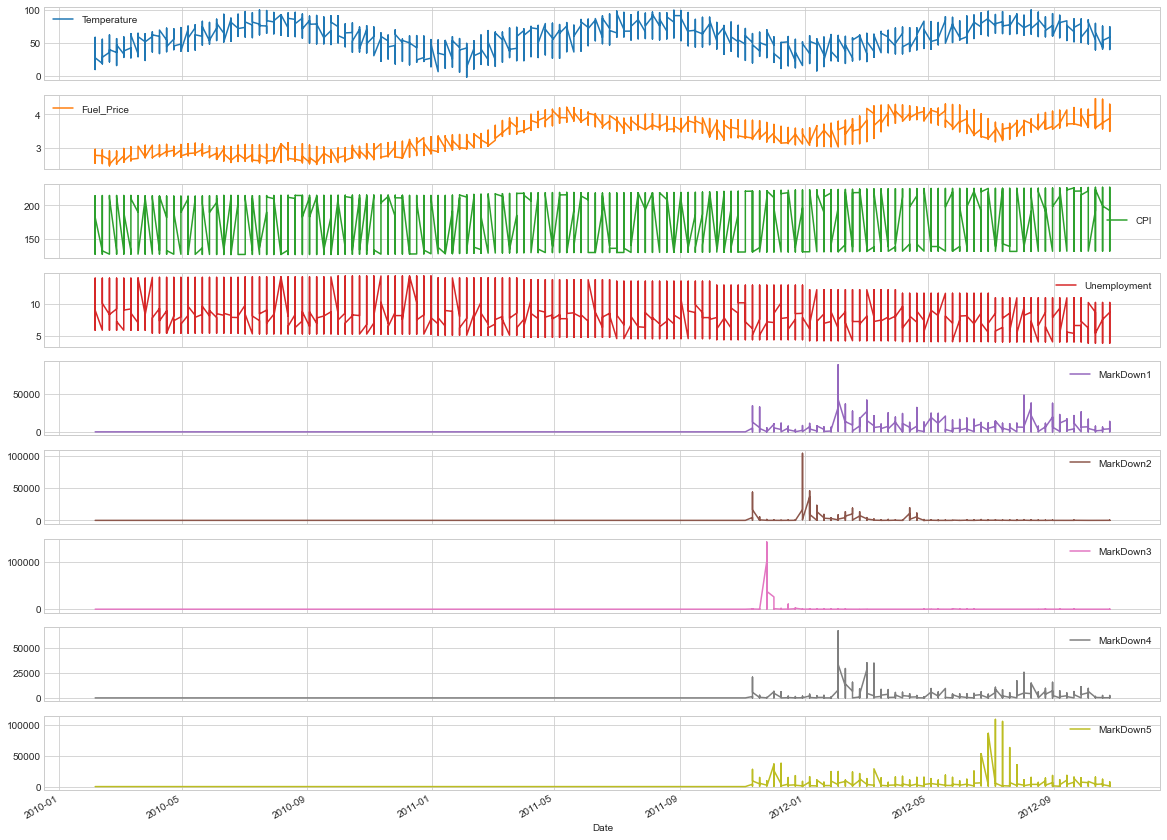

In [32]:
all_train[columns].plot(x='Date', subplots=True, figsize=(20,16))
plt.show()

Fuel price is positive trend.

Temperature seems seasonal.

The Markdowns began appearing in the end of 2011 with some bumps - need to investigate more


In [33]:
all_train.groupby(by='Date', as_index=False)['Weekly_Sales'].sum()

,Date,Weekly_Sales
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


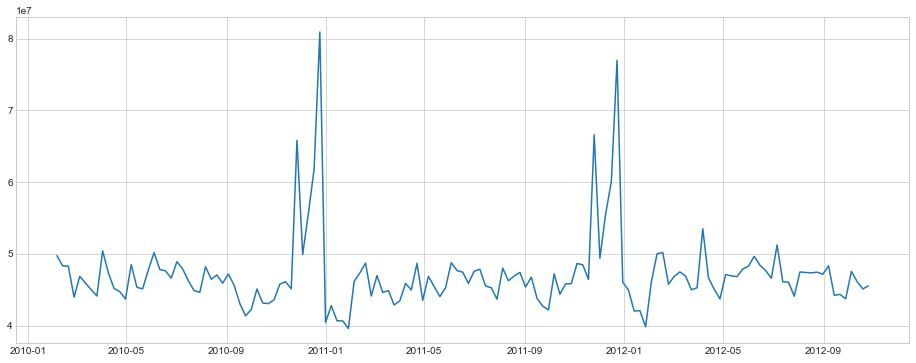

In [36]:
avg_weekly_sales = all_train.groupby(by='Date', as_index=False)['Weekly_Sales'].sum()
avg_sales = avg_weekly_sales.sort_values("Weekly_Sales", ascending=False)
plt.figure(figsize=(16,6))
plt.plot(avg_weekly_sales['Date'], avg_weekly_sales['Weekly_Sales'])
plt.show()

There seems seasonal sales in the end of year. The lowest point is end of January.

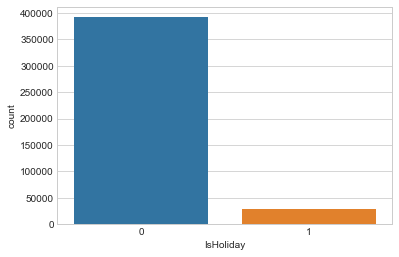

In [37]:
sns.countplot(all_train['IsHoliday'])

Creating dummy for each month

In [38]:
all_train['month'] = all_train['Date'].dt.month
all_train = all_train.drop(['Date'], axis=1)
all_train = pd.get_dummies(all_train, columns=['month'])

all_test['month'] = all_test['Date'].dt.month
all_test = all_test.drop(['Date'], axis=1)
all_test = pd.get_dummies(all_test, columns=['month'])

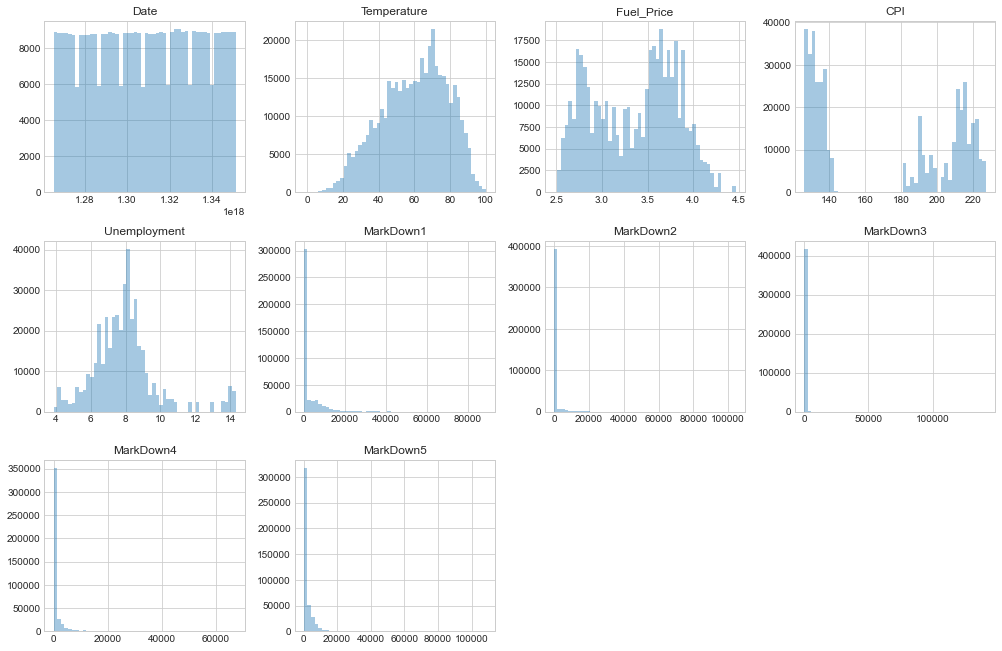

In [302]:
fig = plt.figure(figsize=(14,12))
for index,col in enumerate(columns):
    plt.subplot(4,4,index+1)
    sns.distplot(all_train[col], kde=False)
    plt.xlabel(None)
    plt.title(col, fontsize=12)
fig.tight_layout(pad=1.0)

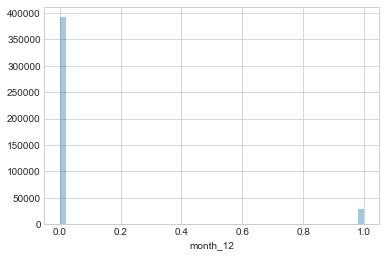

In [43]:
sns.distplot(all_train['month_12'], kde=False)

In [39]:
all_train.corr()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Store,1.000000,0.024004,-0.085195,-0.000548,-0.050097,0.065290,-0.059844,-0.033829,-0.020331,-0.042724,...,-0.000699,-0.000276,0.000335,0.000704,0.001247,0.001266,0.000527,-0.000174,-0.000556,-0.000438
Dept,0.024004,1.000000,0.148032,0.000916,0.004437,0.003572,0.001494,0.000587,0.001475,0.001937,...,-0.000989,-0.001616,0.000473,0.001378,0.001343,0.001403,-0.001181,-0.000761,-0.000620,0.001158
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,-0.002312,-0.000120,0.047172,0.020716,0.038562,0.037467,...,-0.007876,-0.004804,-0.002728,0.004789,-0.001731,0.001129,-0.012330,-0.010273,0.016193,0.040980
IsHoliday,-0.000548,0.000916,0.012774,1.000000,-0.155949,-0.078281,-0.003521,0.207604,0.266471,0.011565,...,-0.087154,-0.090702,-0.083183,-0.086762,-0.090273,-0.086802,0.198821,-0.087043,0.173348,0.139288
Temperature,-0.050097,0.004437,-0.002312,-0.155949,1.000000,0.143859,-0.026415,-0.179672,-0.056026,-0.050281,...,-0.185603,-0.053749,0.079844,0.250365,0.342717,0.320307,0.202357,0.015809,-0.141249,-0.305629
Fuel_Price,0.065290,0.003572,-0.000120,-0.078281,0.143859,1.000000,0.297056,0.029153,0.018615,0.166622,...,0.033025,0.105642,0.144741,0.043538,-0.034652,0.038679,0.051707,-0.006028,-0.091890,-0.118912
MarkDown1,-0.059844,0.001494,0.047172,-0.003521,-0.026415,0.297056,1.000000,0.174868,-0.014411,0.838904,...,0.037532,-0.055291,0.015757,-0.007000,-0.061961,0.088204,-0.020276,-0.079371,-0.011545,-0.036881
MarkDown2,-0.033829,0.000587,0.020716,0.207604,-0.179672,0.029153,0.174868,1.000000,-0.006080,0.113250,...,-0.042499,-0.020548,-0.051985,-0.049911,-0.054372,-0.052760,-0.054217,-0.054428,0.021055,0.182016
MarkDown3,-0.020331,0.001475,0.038562,0.266471,-0.056026,0.018615,-0.014411,-0.006080,1.000000,-0.012020,...,-0.026614,-0.027474,-0.022737,-0.025646,-0.027326,-0.025849,-0.026122,-0.026275,0.302236,0.006582
MarkDown4,-0.042724,0.001937,0.037467,0.011565,-0.050281,0.166622,0.838904,0.113250,-0.012020,1.000000,...,0.029924,-0.062839,-0.029006,-0.037758,-0.011802,0.083472,-0.048166,-0.060122,-0.033091,-0.031218


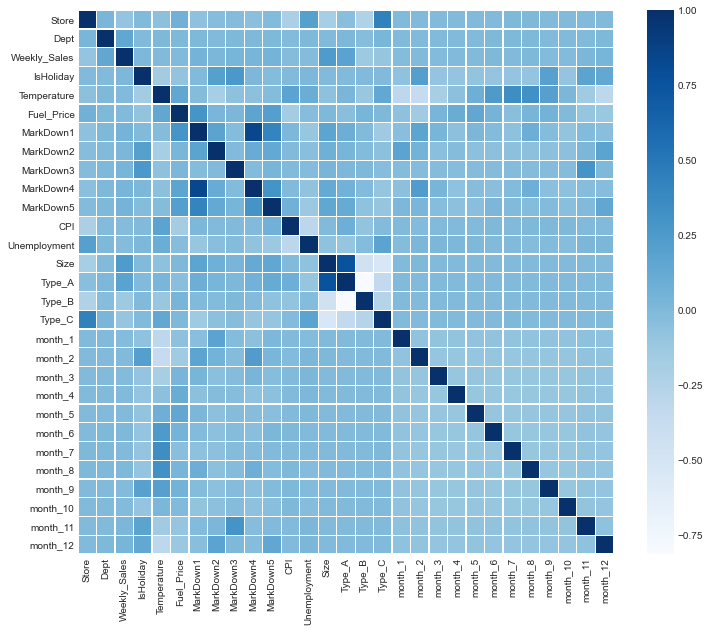

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(all_train.corr(), linewidths=0.2, cmap='Blues')